# 1-4 时间序列数据建模流程
对新冠人数进行预测

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import models, layers, losses, metrics, callbacks

## 1. 观测数据集

In [2]:
%matplotlib inline

df = pd.read_csv('../data/covid-19.csv', sep = '\t')
df.head()

,date,confirmed_num,cured_num,dead_num
0,2020-01-24,830.0,34.0,25.0
1,2020-01-25,1287.0,38.0,41.0
2,2020-01-26,1975.0,49.0,56.0
3,2020-01-27,2744.0,51.0,80.0
4,2020-01-28,4515.0,60.0,106.0


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

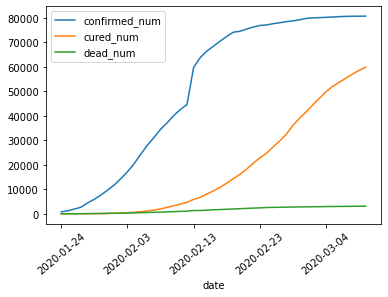

In [3]:
# 绘制图像
df.plot(x = "date", y = ["confirmed_num", "cured_num", "dead_num"])
plt.xticks(rotation = 40)

,confirmed_num,cured_num,dead_num
0,457.0,4.0,16.0
1,688.0,11.0,15.0
2,769.0,2.0,24.0
3,1771.0,9.0,26.0
4,1459.0,43.0,26.0


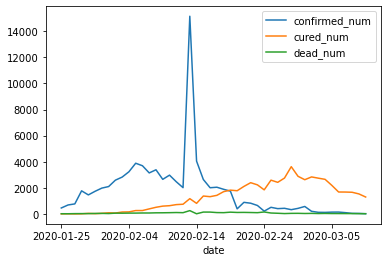

In [4]:
# 观测时间序列的差分数据
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()  # 避免差分掉date
dfdiff = dfdiff.reset_index("date")  # 将date列还原回来
dfdiff.plot(x = "date", y = ["confirmed_num", "cured_num", "dead_num"])

dfdiff = dfdiff.drop("date", axis = 1).astype("float32")
dfdiff.head()

## 2 构建数据集

In [5]:
window_size = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(window_size, drop_remainder = True)  # 丢掉最后一个小于windows_size的batch
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values, dtype = tf.float32)).window(window_size, shift = 1).flat_map(batch_dataset)
ds_label = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values[window_size:], dtype = tf.float32))

for data in ds_label.take(3):
    print(data)

tf.Tensor([2589.   69.   61.], shape=(3,), dtype=float32)
tf.Tensor([2825.  147.   57.], shape=(3,), dtype=float32)
tf.Tensor([3233.  157.   64.], shape=(3,), dtype=float32)


In [6]:
ds_train = tf.data.Dataset.zip((ds_data, ds_label)).batch(64).cache()  # 把x和y压缩到一起去
for d in ds_train.unbatch().take(1):
    print(d)

(<tf.Tensor: shape=(8, 3), dtype=float32, numpy=
array([[4.570e+02, 4.000e+00, 1.600e+01],
       [6.880e+02, 1.100e+01, 1.500e+01],
       [7.690e+02, 2.000e+00, 2.400e+01],
       [1.771e+03, 9.000e+00, 2.600e+01],
       [1.459e+03, 4.300e+01, 2.600e+01],
       [1.737e+03, 2.100e+01, 3.800e+01],
       [1.981e+03, 4.700e+01, 4.300e+01],
       [2.099e+03, 8.800e+01, 3.000e+01]], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([2589.,   69.,   61.], dtype=float32)>)


## 3 构建模型
用Keras较为简单, 不用类进行封装

In [10]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None, 3), dtype = tf.float32)
x = layers.LSTM(3, return_sequences = True)(x_input)
x = layers.LSTM(3, return_sequences = True)(x)
x = layers.LSTM(3, return_sequences = True)(x)
x = layers.LSTM(3)(x)
x_output = layers.Dense(3)(x)
model = tf.keras.Model(inputs = [x_input], outputs = [x_output])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 3)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 3)           84        
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 3)           84        
_________________________________________________________________
lstm_3 (LSTM)                (None, 3)                 84        
_________________________________________________________________
dense (Dense)                (None, 3)                 12        
Total params: 348
Trainable params: 348
Non-trainable params: 0
_______________________________________________________________

### 4 训练模型

In [11]:
# 自定义损失函数
class MSPE(losses.Loss):
    def call(self, y_true, y_pred):
        err_percent = (y_true - y_pred)**2 / tf.maximum(y_true**2, 1e-7)
        return tf.reduce_mean(err_percent)

# 开始训练
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss = MSPE())

# 使用tensorboard
logdir = './1-3_keras_model_log'
tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq = 1)
# 如果在20个epoch后没有提升, 学习率减半
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.5, patience = 20)
# 如果40个epoch后没有提升, 就停止训练
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 40)
callbacks_list = [tb_callback, lr_callback, stop_callback]
history = model.fit(ds_train, epochs = 60, callbacks = callbacks_list, verbose = 2)

Epoch 1/60
1/1 - 0s - loss: 1.0004 - lr: 0.0100
Epoch 2/60
1/1 - 0s - loss: 0.9995 - lr: 0.0100
Epoch 3/60
1/1 - 0s - loss: 0.9993 - lr: 0.0100
Epoch 4/60
1/1 - 0s - loss: 0.9982 - lr: 0.0100
Epoch 5/60
1/1 - 0s - loss: 0.9973 - lr: 0.0100
Epoch 6/60
1/1 - 0s - loss: 0.9965 - lr: 0.0100
Epoch 7/60
1/1 - 0s - loss: 0.9955 - lr: 0.0100
Epoch 8/60
1/1 - 0s - loss: 0.9945 - lr: 0.0100
Epoch 9/60
1/1 - 0s - loss: 0.9933 - lr: 0.0100
Epoch 10/60
1/1 - 0s - loss: 0.9918 - lr: 0.0100
Epoch 11/60
1/1 - 0s - loss: 0.9904 - lr: 0.0100
Epoch 12/60
1/1 - 0s - loss: 0.9888 - lr: 0.0100
Epoch 13/60
1/1 - 0s - loss: 0.9872 - lr: 0.0100
Epoch 14/60
1/1 - 0s - loss: 0.9855 - lr: 0.0100
Epoch 15/60
1/1 - 0s - loss: 0.9838 - lr: 0.0100
Epoch 16/60
1/1 - 0s - loss: 0.9822 - lr: 0.0100
Epoch 17/60
1/1 - 0s - loss: 0.9805 - lr: 0.0100
Epoch 18/60
1/1 - 0s - loss: 0.9789 - lr: 0.0100
Epoch 19/60
1/1 - 0s - loss: 0.9773 - lr: 0.0100
Epoch 20/60
1/1 - 0s - loss: 0.9758 - lr: 0.0100
Epoch 21/60
1/1 - 0s - loss: 